<a href="https://colab.research.google.com/github/a-delicate-balance/brain-tumor-analysis/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage.transform import resize
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import kagglehub

# Download latest version
ROOT_PATH = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", ROOT_PATH)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=224

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        img_resized = cv2.resize(img_array, (image_size, image_size))
        X_train.append(img_resized)
        Y_train.append(class_num)

for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        img_resized = cv2.resize(img_array, (image_size, image_size))
        X_train.append(img_resized)
        Y_train.append(class_num)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
X_train.shape

(7023, 224, 224, 3)

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [ ]:
X_train.shape

(7023, 224, 224, 3)

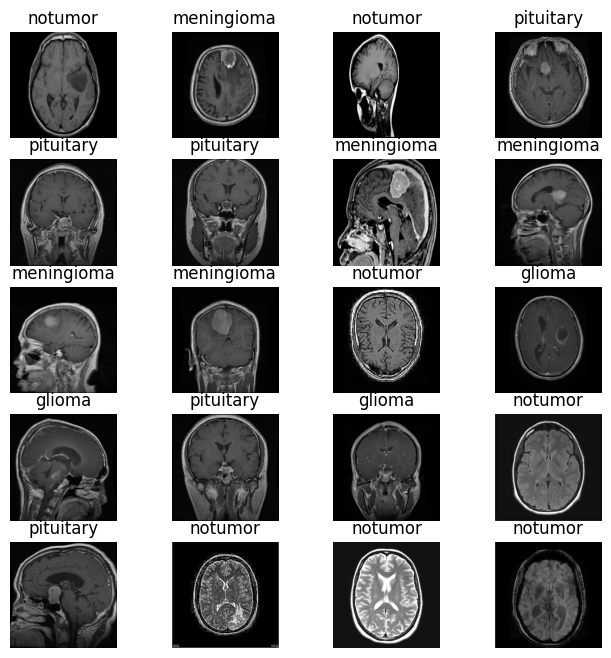

In [ ]:
plt.figure(figsize=(8,8))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# convert string to categorical
y_train_new = to_categorical(Y_train, num_classes=4)
y_valid_new = to_categorical(Y_valid, num_classes=4)
y_test_new = to_categorical(Y_test, num_classes=4)

In [ ]:
from keras.applications import ResNet50

# Load ResNet50 model with pre-trained weights
base_model = ResNet50(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')

# Unfreeze some layers in the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('Bmodel.keras', monitor='val_loss', save_best_only=True)

# Model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train_new, batch_size=32),
                    epochs=10,  # Increase the number of epochs as needed
                    validation_data=(X_valid, y_valid_new),
                    callbacks=[early_stopping, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 151s 580ms/step - accuracy: 0.5619 - loss: 1.1671 - val_accuracy: 0.7260 - val_loss: 0.7761
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 75s 471ms/step - accuracy: 0.8599 - loss: 0.3771 - val_accuracy: 0.7900 - val_loss: 0.6370
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 513ms/step - accuracy: 0.9083 - loss: 0.2603 - val_accuracy: 0.9235 - val_loss: 0.2005
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 525ms/step - accuracy: 0.9309 - loss: 0.1845 - val_accuracy: 0.9413 - val_loss: 0.1718
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 523ms/step - accuracy: 0.9526 - loss: 0.1470 - val_accuracy: 0.9698 - val_loss: 0.0867
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 72s 457ms/step - accuracy: 0.9619 - loss: 0.1173 - val_accuracy: 0.9431 - val_loss: 0.1755
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 73s 460ms/step - accuracy: 0.9650 - loss: 0.1046 - val_accuracy: 0.9751 - val_loss: 0.0912
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 92s 581ms/step - accuracy: 0.9731 - loss: 

In [ ]:
model = load_model('Bmodel.keras')

44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.9726 - loss: 0.0862


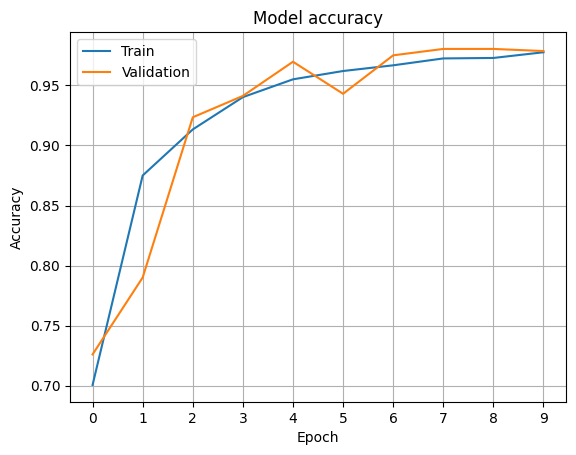

In [ ]:
model.evaluate(X_test, y_test_new)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([x for x in range(len(history.history['accuracy']))])
plt.show()

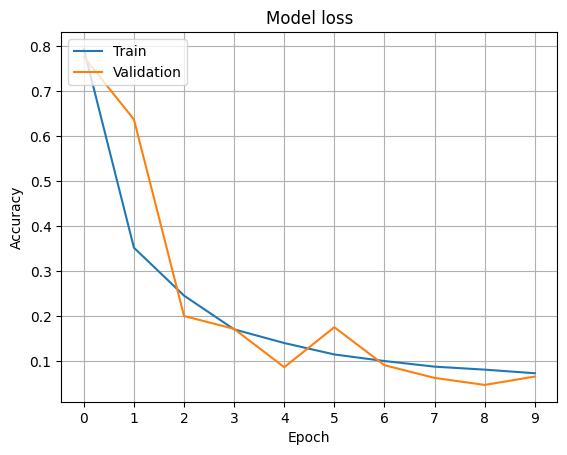

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks([x for x in range(len(history.history['accuracy']))])
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step


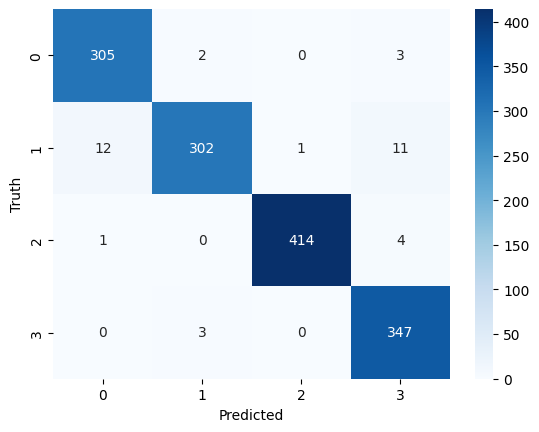

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       310
  meningioma       0.98      0.93      0.95       326
     notumor       1.00      0.99      0.99       419
   pituitary       0.95      0.99      0.97       350

    accuracy                           0.97      1405
   macro avg       0.97      0.97      0.97      1405
weighted avg       0.97      0.97      0.97      1405



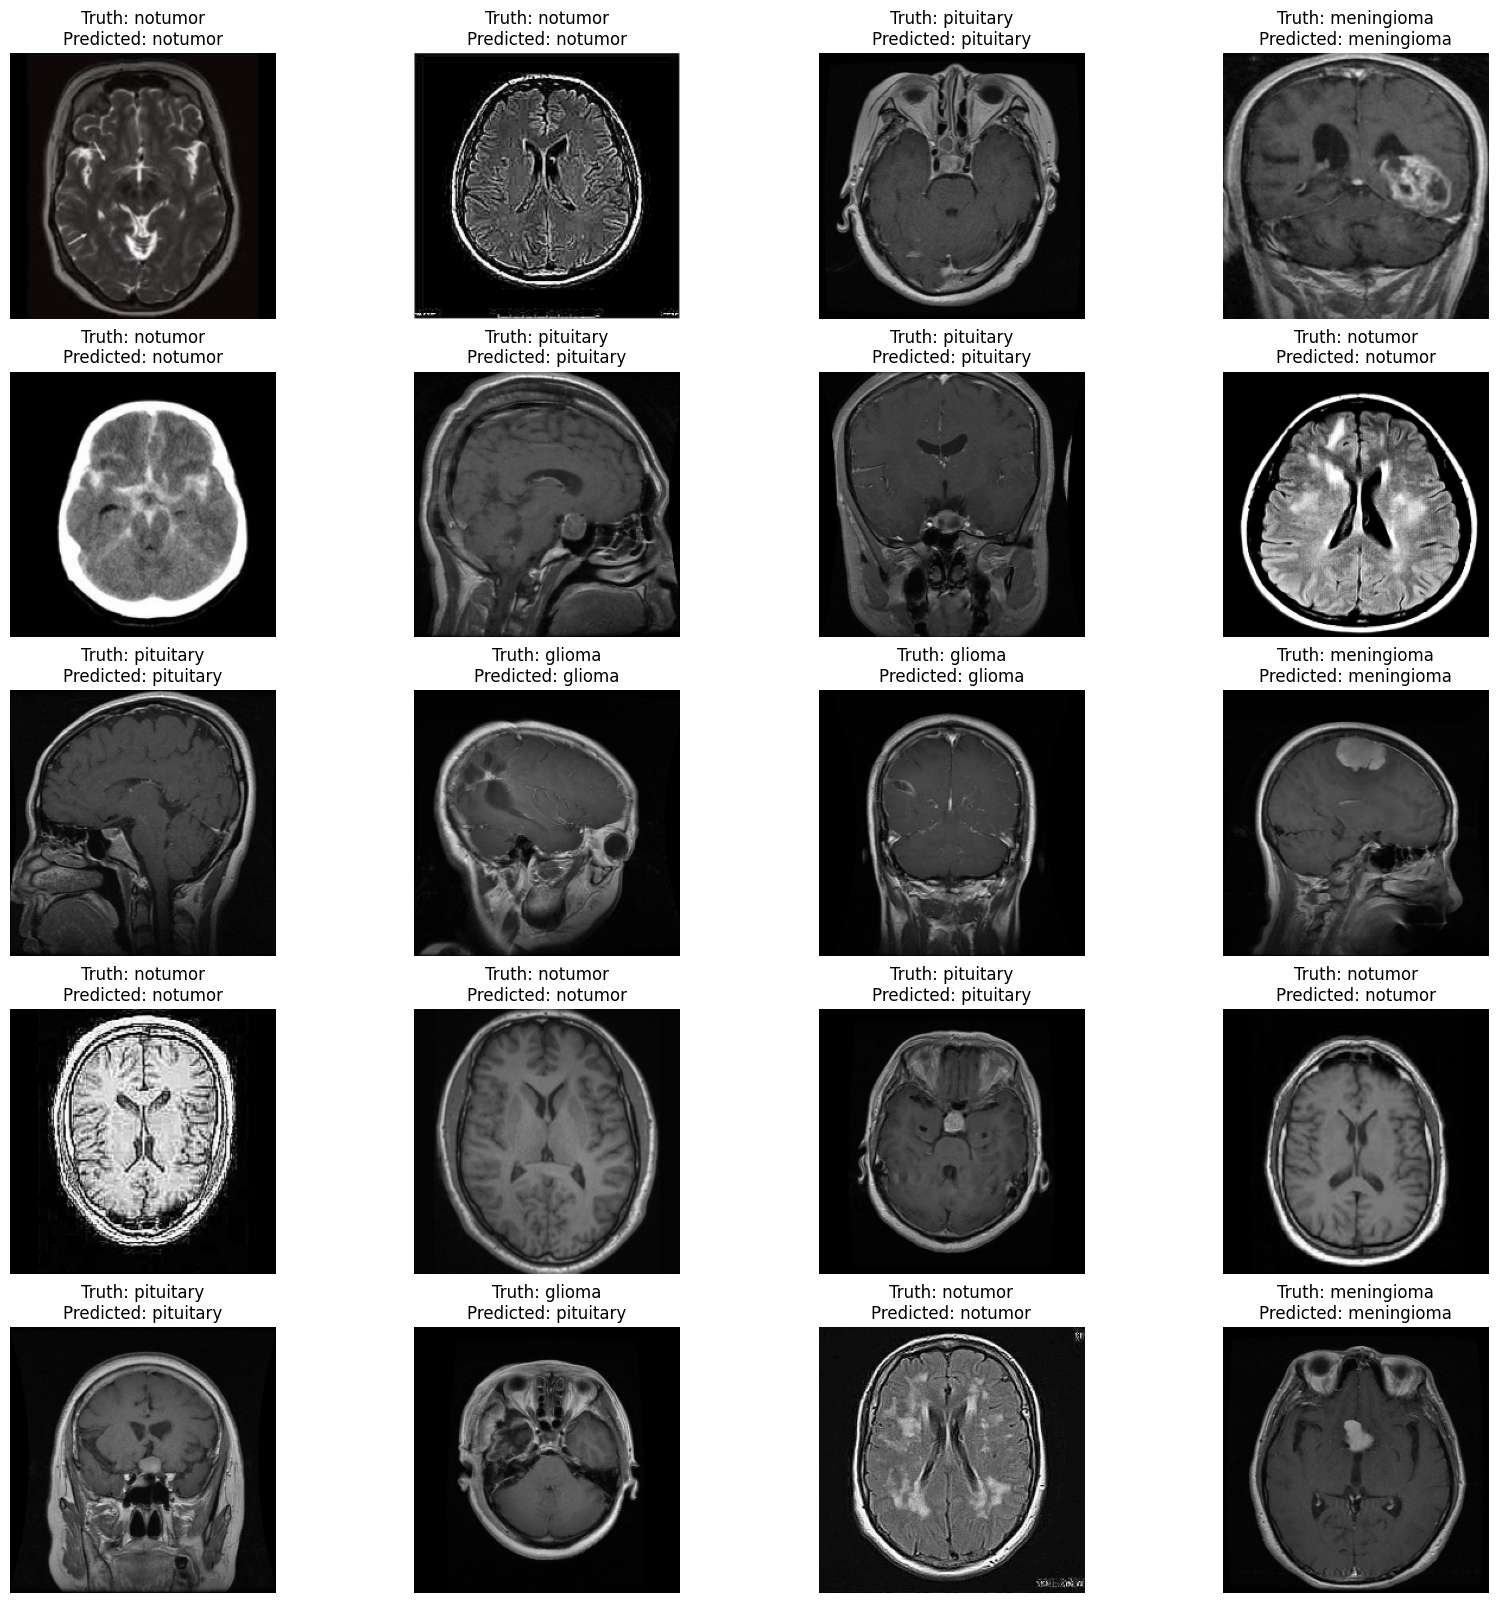

In [ ]:
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {labels[Y_test[i]]}\nPredicted: {labels[y_pred[i]]}")
    plt.axis('off')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
print(f"Accuracy: {accuracy_score(Y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(Y_test, y_pred, average='weighted') * 100:.2f}%")
print(f"Recall: {recall_score(Y_test, y_pred, average='weighted') * 100:.2f}%")
print(f"F1: {f1_score(Y_test, y_pred, average='weighted') * 100:.2f}%")

Accuracy: 97.37%
Precision: 97.42%
Recall: 97.37%
F1: 97.36%
